In [91]:
import cv2 as cv
import numpy as np
import random
from PIL import Image
from image_utils import *
from blank import *
from sampling import Sampler
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
def parse_cfg(cfg_path):
    
    # only supports distributon configs for now
    
    cfg = {}
    
    with open(cfg_path) as f:
        for line in f:          
            line = line.strip()
            if line[0] == '#':
                continue
            else:
                key,value = line.split('=')
                
                key = key.strip()
                value = float(value.strip())
                
                cfg[key] = value
                
                
    return cfg  

In [93]:
def get_img_data(directory_path):
    
    path_slash = '\\' if os.name == 'nt' else '/'
    
    if directory_path[-1] != path_slash:
        directory_path += path_slash
        
    img_names = []
    imgs = []
    
    for file_name in glob.glob(directory_path + '*'):
        
        if '.cfg' in file_name:
            cfg = parse_cfg(file_name)
            cfg = {k.replace('.npy', '') : v for k,v in cfg.items()} # removing potential .npy extension from key(name)
        else:
            cur_img = np.load(file_name)
            imgs.append(cur_img)
            
            cur_img_name = file_name.split(path_slash)[-1]
            cur_img_name = cur_img_name.split('.')[0]         
            img_names.append(cur_img_name)
            
    
    distribution = []
    
    for img_name in img_names:
        distribution.append(cfg[img_name])
    
    return img_names, imgs, distribution

In [94]:
def display(img):
    return Image.fromarray(img)

In [95]:
a = get_blanks('blanks')[2]
a.img = adaptive_thresh(a.img)
names, imgs, distr = get_img_data('nums')
num_sampler = Sampler(imgs, distr)
cnt = 0

while cnt < 80:
    row = random.randint(a.min_row, a.max_row)
    col = random.randint(a.min_col, a.max_col)
    
    st = num_sampler.get_sample()
    st = adaptive_thresh(st)
    
    while not a.place_object(st, (row, col)):
        row = random.randint(a.min_row, a.max_row)
        col = random.randint(a.min_col, a.max_col)
        continue
    
    cnt += 1


In [211]:
def place_above(blank, num, dot_coords):

    top_left_row = dot_coords['min row'] - num.shape[0] - random.randint(0, 10)
    top_left_col = dot_coords['min col'] + random.randint(-20, 20)
    
    return blank.place_object(num, (top_left_row, top_left_col))

def place_below(blank, num, dot_coords):
        
    top_left_row = dot_coords['max row'] + random.randint(0, 10)
    top_left_col = dot_coords['min col'] + random.randint(-20, 20)
    
    return blank.place_object(num, (top_left_row, top_left_col))

def place_right(blank, num, dot_coords):
    
    top_left_row = dot_coords['min row'] + random.randint(-20, 20)
    top_left_col = dot_coords['max col'] + random.randint(0, 10)
    
    return blank.place_object(num, (top_left_row, top_left_col))

def place_left(blank, num, dot_coords):
    
    top_left_row = dot_coords['min row'] + random.randint(-20, 20)
    top_left_col = dot_coords['min col'] - num.shape[1] - random.randint(0, 10)
    
    return blank.place_object(num, (top_left_row, top_left_col))

In [241]:
a = get_blanks('blanks')[1]
a.img = adaptive_thresh(a.img)

for i in range(30):
    dot = np.load('dots/dot1.npy')
    dot = adaptive_thresh(dot)
    
    row = random.randint(a.min_row, a.max_row)
    col = random.randint(a.min_col, a.max_col)
    
    while not a.place_object(dot, (row, col)):
        row = random.randint(a.min_row, a.max_row)
        col = random.randint(a.min_col, a.max_col)
    
    # placed dot
    
    num = np.load('nums/five.npy')
    num = adaptive_thresh(num)
    num = cv.resize(num, (30,30))

    top_left = row, col
    bot_right = row+dot.shape[0], col+dot.shape[1]
    
    dot_coords = {}
    dot_coords['min row'] = top_left[0]
    dot_coords['max row'] = bot_right[0]
    dot_coords['min col'] = top_left[1]
    dot_coords['max col'] = bot_right[1]

    
    (place_left(a, num, dot_coords))

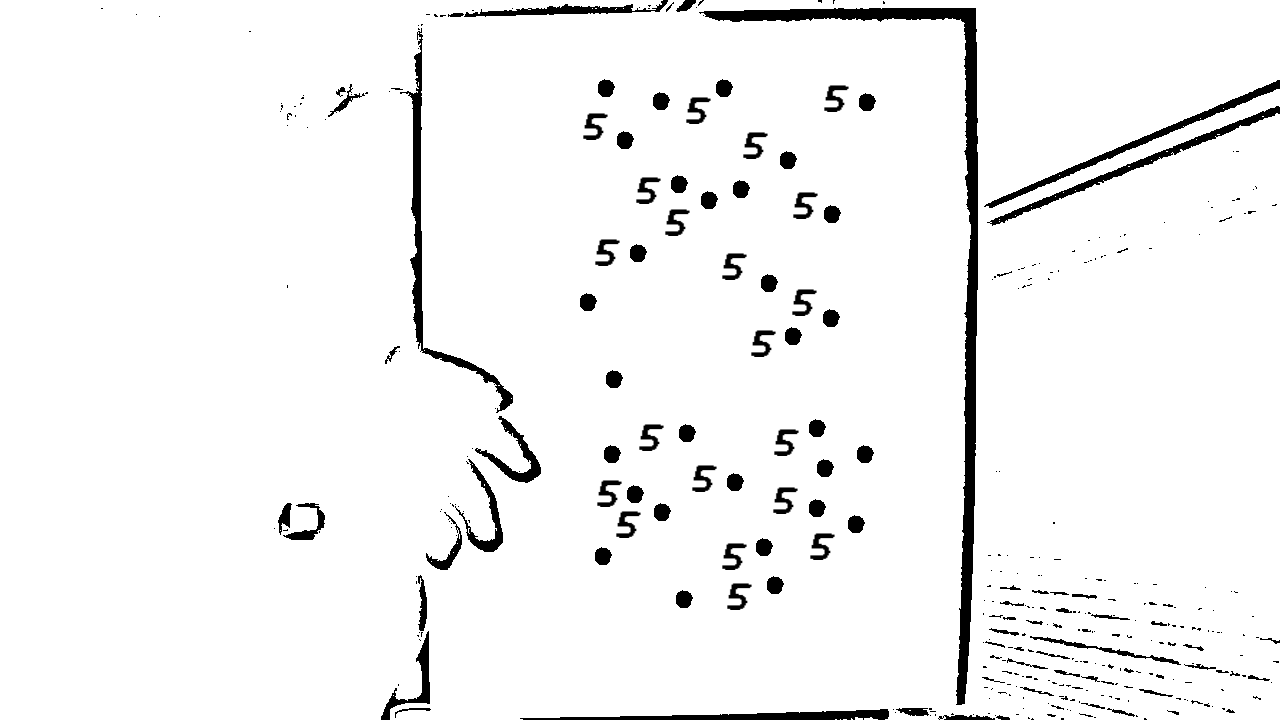

In [242]:
display(a.img)